<a href="https://colab.research.google.com/github/HimadriPrakash/Cardiac-Sentinel-Risk-Analysis-using-LGBM/blob/main/minor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing all the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from scipy.stats import uniform

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
#connecting to google drive
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path="/content/drive/MyDrive/heart.csv"

In [ ]:
data=pd.read_csv(path)
print('Shape of the data is ', data.shape)

Shape of the data is  (303, 14)


In [ ]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [ ]:
data = data[data['ca'] < 4] #drop the wrong ca values
data = data[data['thal'] > 0] # drop the wong thal value
print(f'The length of the data now is {len(data)} instead of 303!')

The length of the data now is 296 instead of 303!


There are some feature name that are slight hard to understand so we will rename all the names to make it easier to understand

In [ ]:
data = data.rename(
    columns = {'cp':'chest_pain_type',
               'trestbps':'resting_blood_pressure',
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram',
               'thalach': 'max_heart_rate_achieved',
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression',
               'slope': 'st_slope',
               'ca':'num_major_vessels',
               'thal': 'thalassemia'},
    errors="raise")

#0 for female
#1 for male

In [ ]:
data['sex'][data['sex'] == 0] = 'female'
data['sex'][data['sex'] == 1] = 'male'

data['chest_pain_type'][data['chest_pain_type'] == 0] = 'typical angina'
data['chest_pain_type'][data['chest_pain_type'] == 1] = 'atypical angina'
data['chest_pain_type'][data['chest_pain_type'] == 2] = 'non-anginal pain'
data['chest_pain_type'][data['chest_pain_type'] == 3] = 'asymptomatic'

data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 0] = 'normal'
data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 1] = 'ST-T wave abnormality'
data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 2] = 'left ventricular hypertrophy'

data['exercise_induced_angina'][data['exercise_induced_angina'] == 0] = 'no'
data['exercise_induced_angina'][data['exercise_induced_angina'] == 1] = 'yes'

data['st_slope'][data['st_slope'] == 0] = 'upsloping'
data['st_slope'][data['st_slope'] == 1] = 'flat'
data['st_slope'][data['st_slope'] == 2] = 'downsloping'

data['thalassemia'][data['thalassemia'] == 1] = 'fixed defect'
data['thalassemia'][data['thalassemia'] == 2] = 'normal'
data['thalassemia'][data['thalassemia'] == 3] = 'reversable defect'

In [ ]:
data.dtypes

age                            int64
sex                           object
chest_pain_type               object
resting_blood_pressure         int64
cholesterol                    int64
fasting_blood_sugar           object
resting_electrocardiogram     object
max_heart_rate_achieved        int64
exercise_induced_angina       object
st_depression                float64
st_slope                      object
num_major_vessels              int64
thalassemia                   object
target                         int64
dtype: object

In [ ]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,asymptomatic,145,233,greater than 120mg/ml,normal,150,no,2.3,upsloping,0,fixed defect,1
1,37,male,non-anginal pain,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,upsloping,0,normal,1
2,41,female,atypical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,downsloping,0,normal,1
3,56,male,atypical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,downsloping,0,normal,1
4,57,female,typical angina,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,downsloping,0,normal,1


As we have seen above there are three datatypes i.e object, int and floats. Let's group them according to type.

In [ ]:
# numerical fearures 6
num_feats = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']
# categorical (binary)
bin_feats = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']
# caterorical (multi-)
nom_feats= ['chest_pain_type', 'resting_electrocardiogram', 'st_slope', 'thalassemia']
cat_feats = nom_feats + bin_feats

*Target distribution*

We observe that the target is fairly balanced with ~46% with no heart disease and ~54% with heart disease. So no need to worry about target imbalance.

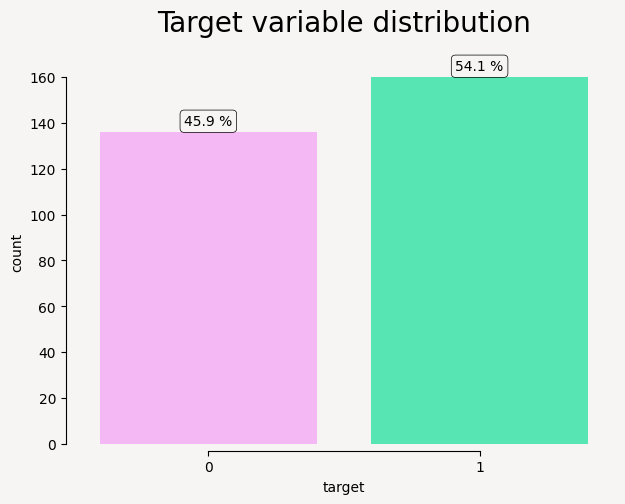

In [ ]:
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

plt.figure(figsize=(7, 5),facecolor='#F6F5F4')
total = float(len(data))
ax = sns.countplot(x=data['target'], palette=mypal[1::4])
ax.set_facecolor('#F6F5F4')

for p in ax.patches:

    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Target variable distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

For the numerical features we can apply the handy pandas data.describe() method and get the global statistical summary. Key figures are highlighted below.

In [ ]:
data[num_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
cholesterol,296.0,247.155405,51.977011,126.0,211.0,242.5,275.25,564.0
resting_blood_pressure,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
max_heart_rate_achieved,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
st_depression,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2
num_major_vessels,296.0,0.679054,0.939726,0.0,0.0,0.0,1.00,3.0


Below is the Density plot

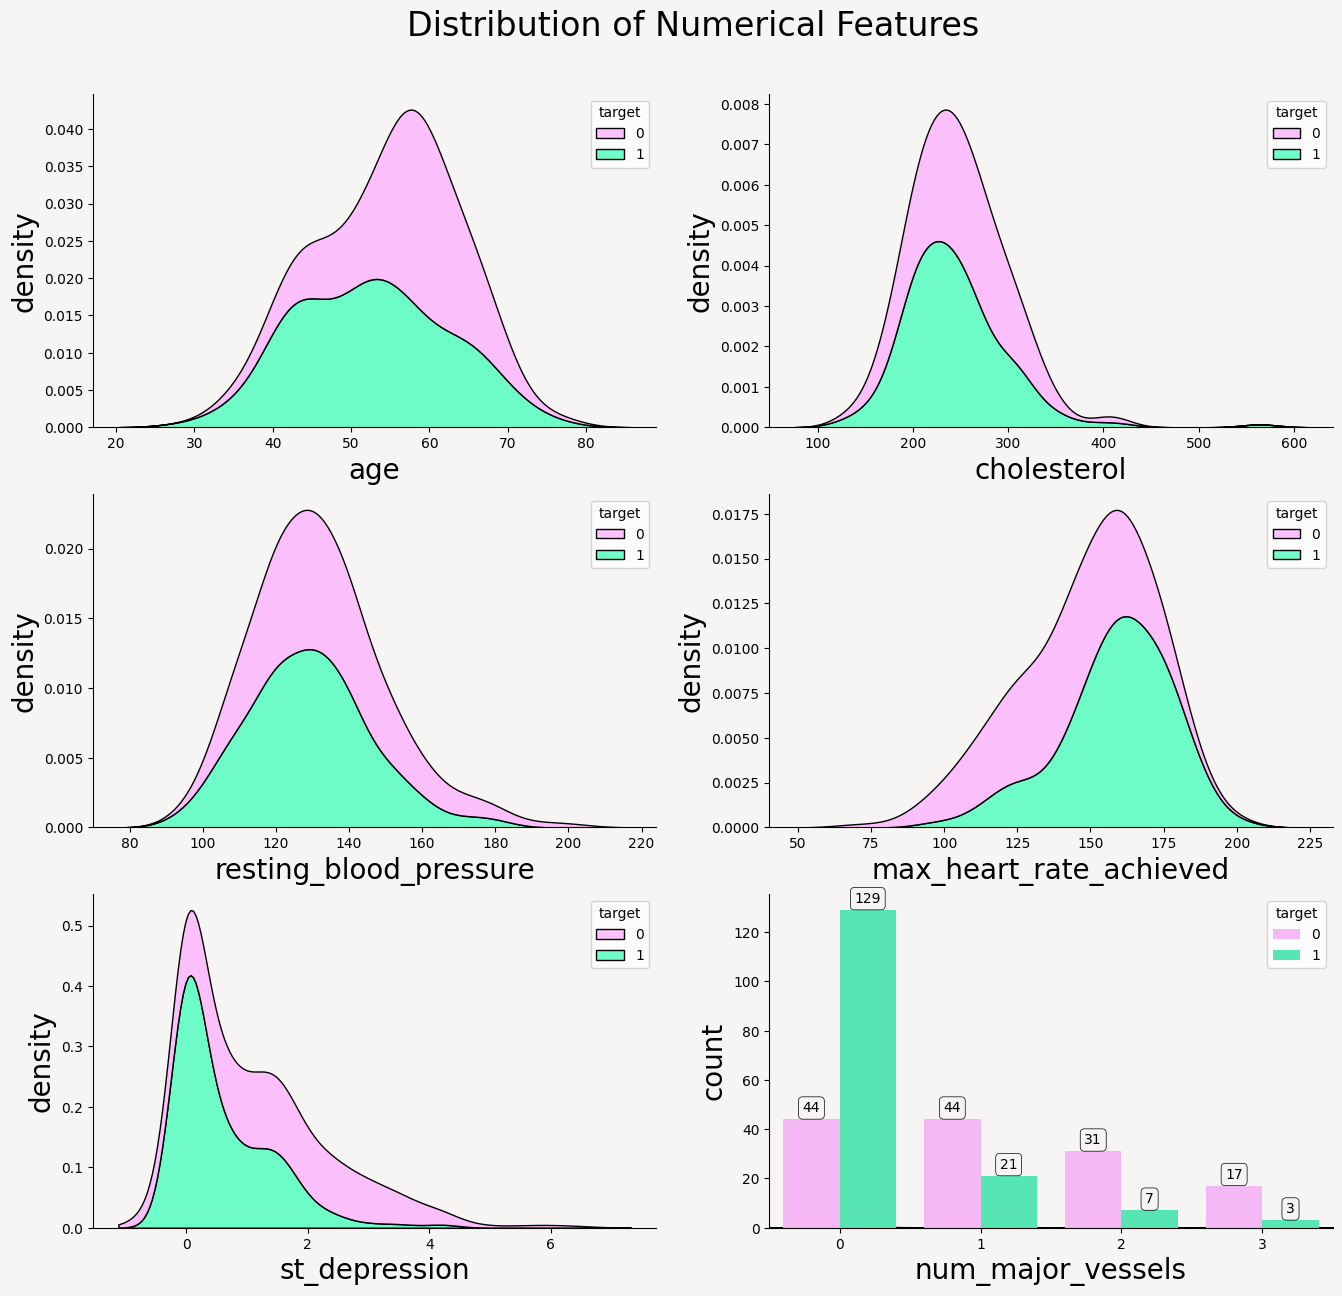

In [ ]:
L = len(num_feats)
ncol= 2
nrow= int(np.ceil(L/ncol))
#remove_last= (nrow * ncol) - L

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')
fig.subplots_adjust(top=0.92)

i = 1
for col in num_feats:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')

    ax = sns.kdeplot(data=data, x=col, hue="target", multiple="stack", palette=mypal[1::4])
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)

    if col == 'num_major_vessels':
        sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

    i = i +1
plt.suptitle('Distribution of Numerical Features' ,fontsize = 24);

Pair plot

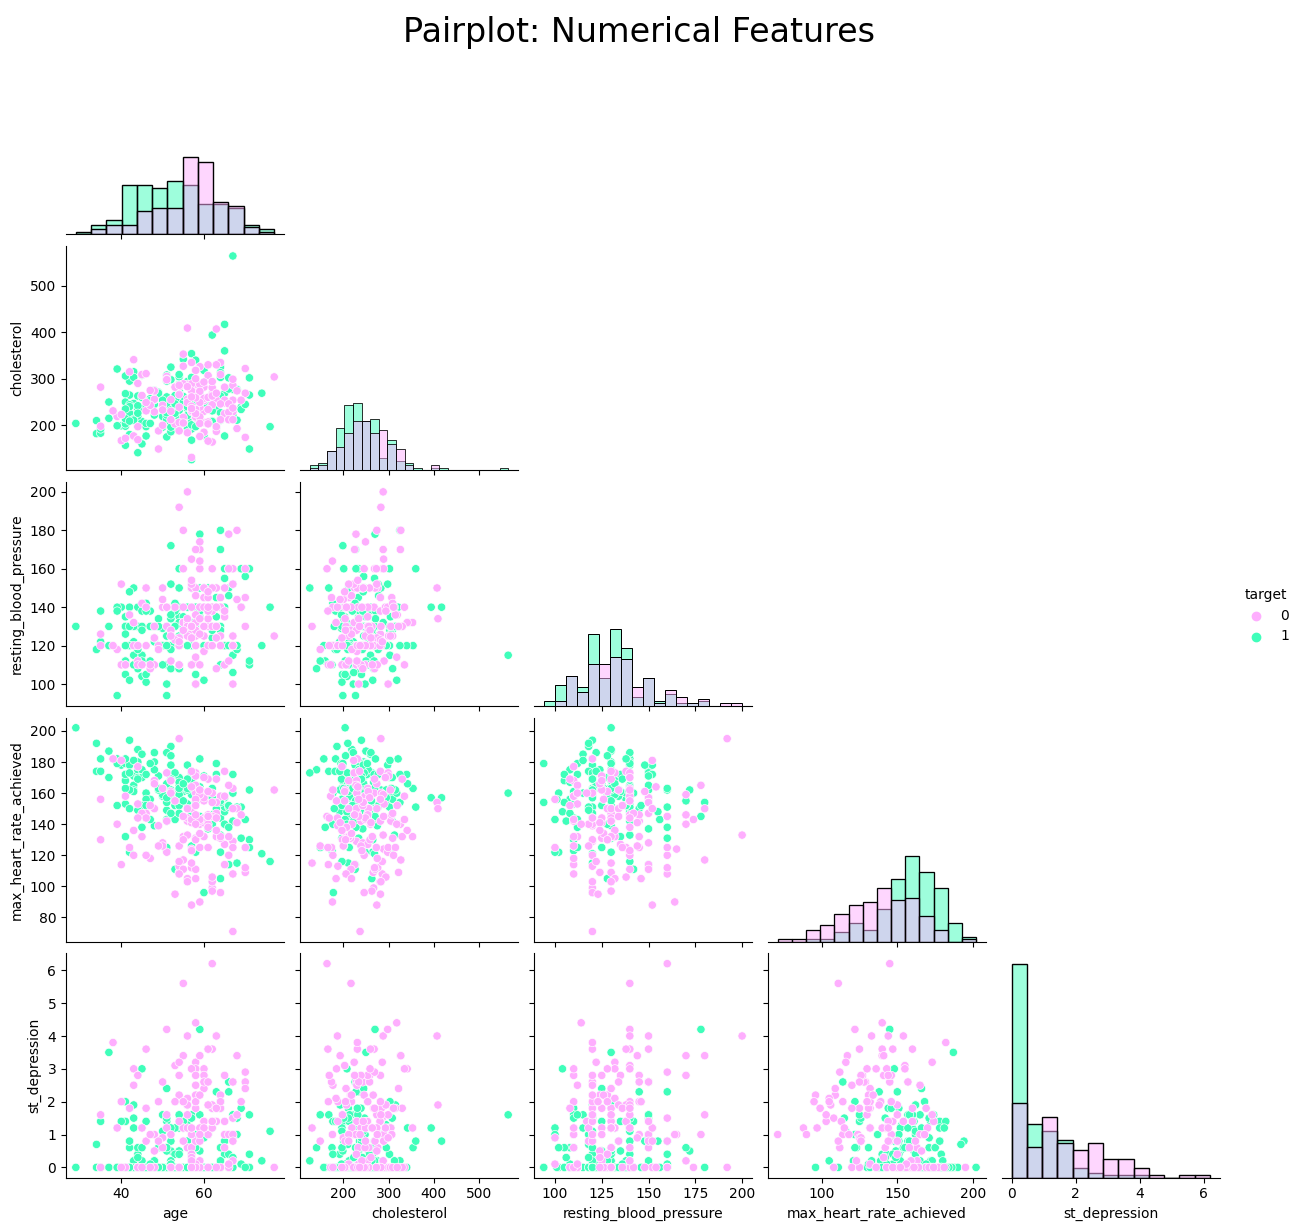

In [ ]:
_ = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'target']
data_ = data[_]
g = sns.pairplot(data_, hue="target", corner=True, diag_kind='hist', palette=mypal[1::4]);
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 24);

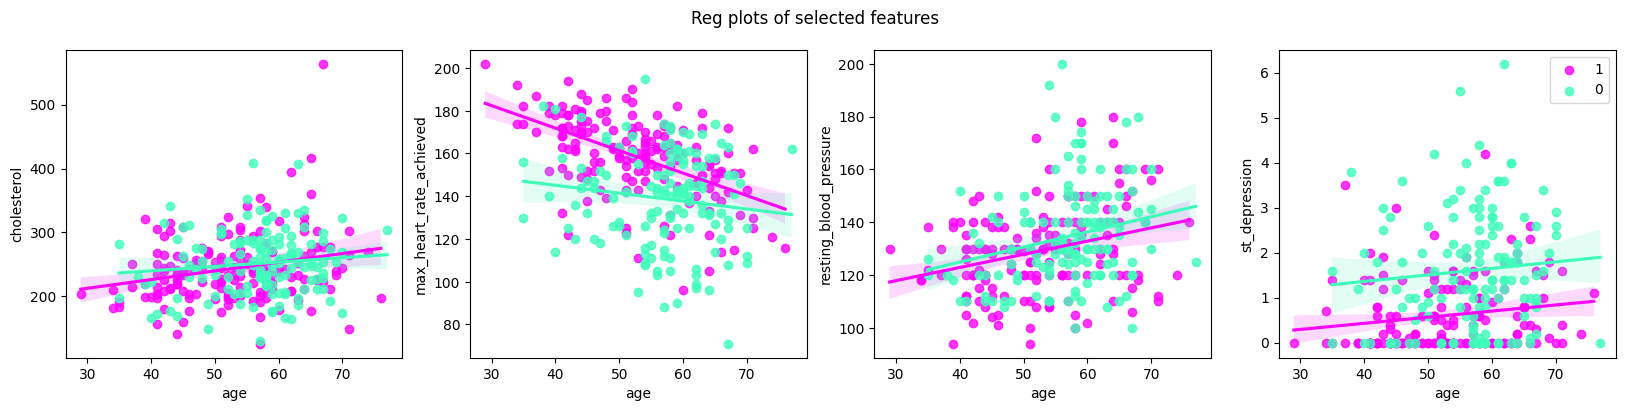

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))
sns.regplot(data=data[data['target'] ==1], x='age', y='cholesterol', ax = ax[0], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='cholesterol', ax = ax[0], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[5], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='st_depression', ax = ax[3], color=mypal[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='st_depression', ax = ax[3], color=mypal[5], label='0')
plt.suptitle('Reg plots of selected features')
plt.legend();

Categorical feature!

We use a count plot to visualize the different categories with respect to the target variable. Two things we could take note of are the distribution of each category in the dataset and their contribution to the probability of correct prediction of the target variable, i.e has disease (=1) or has no disease (=0). Below is the summary of the categorical features.

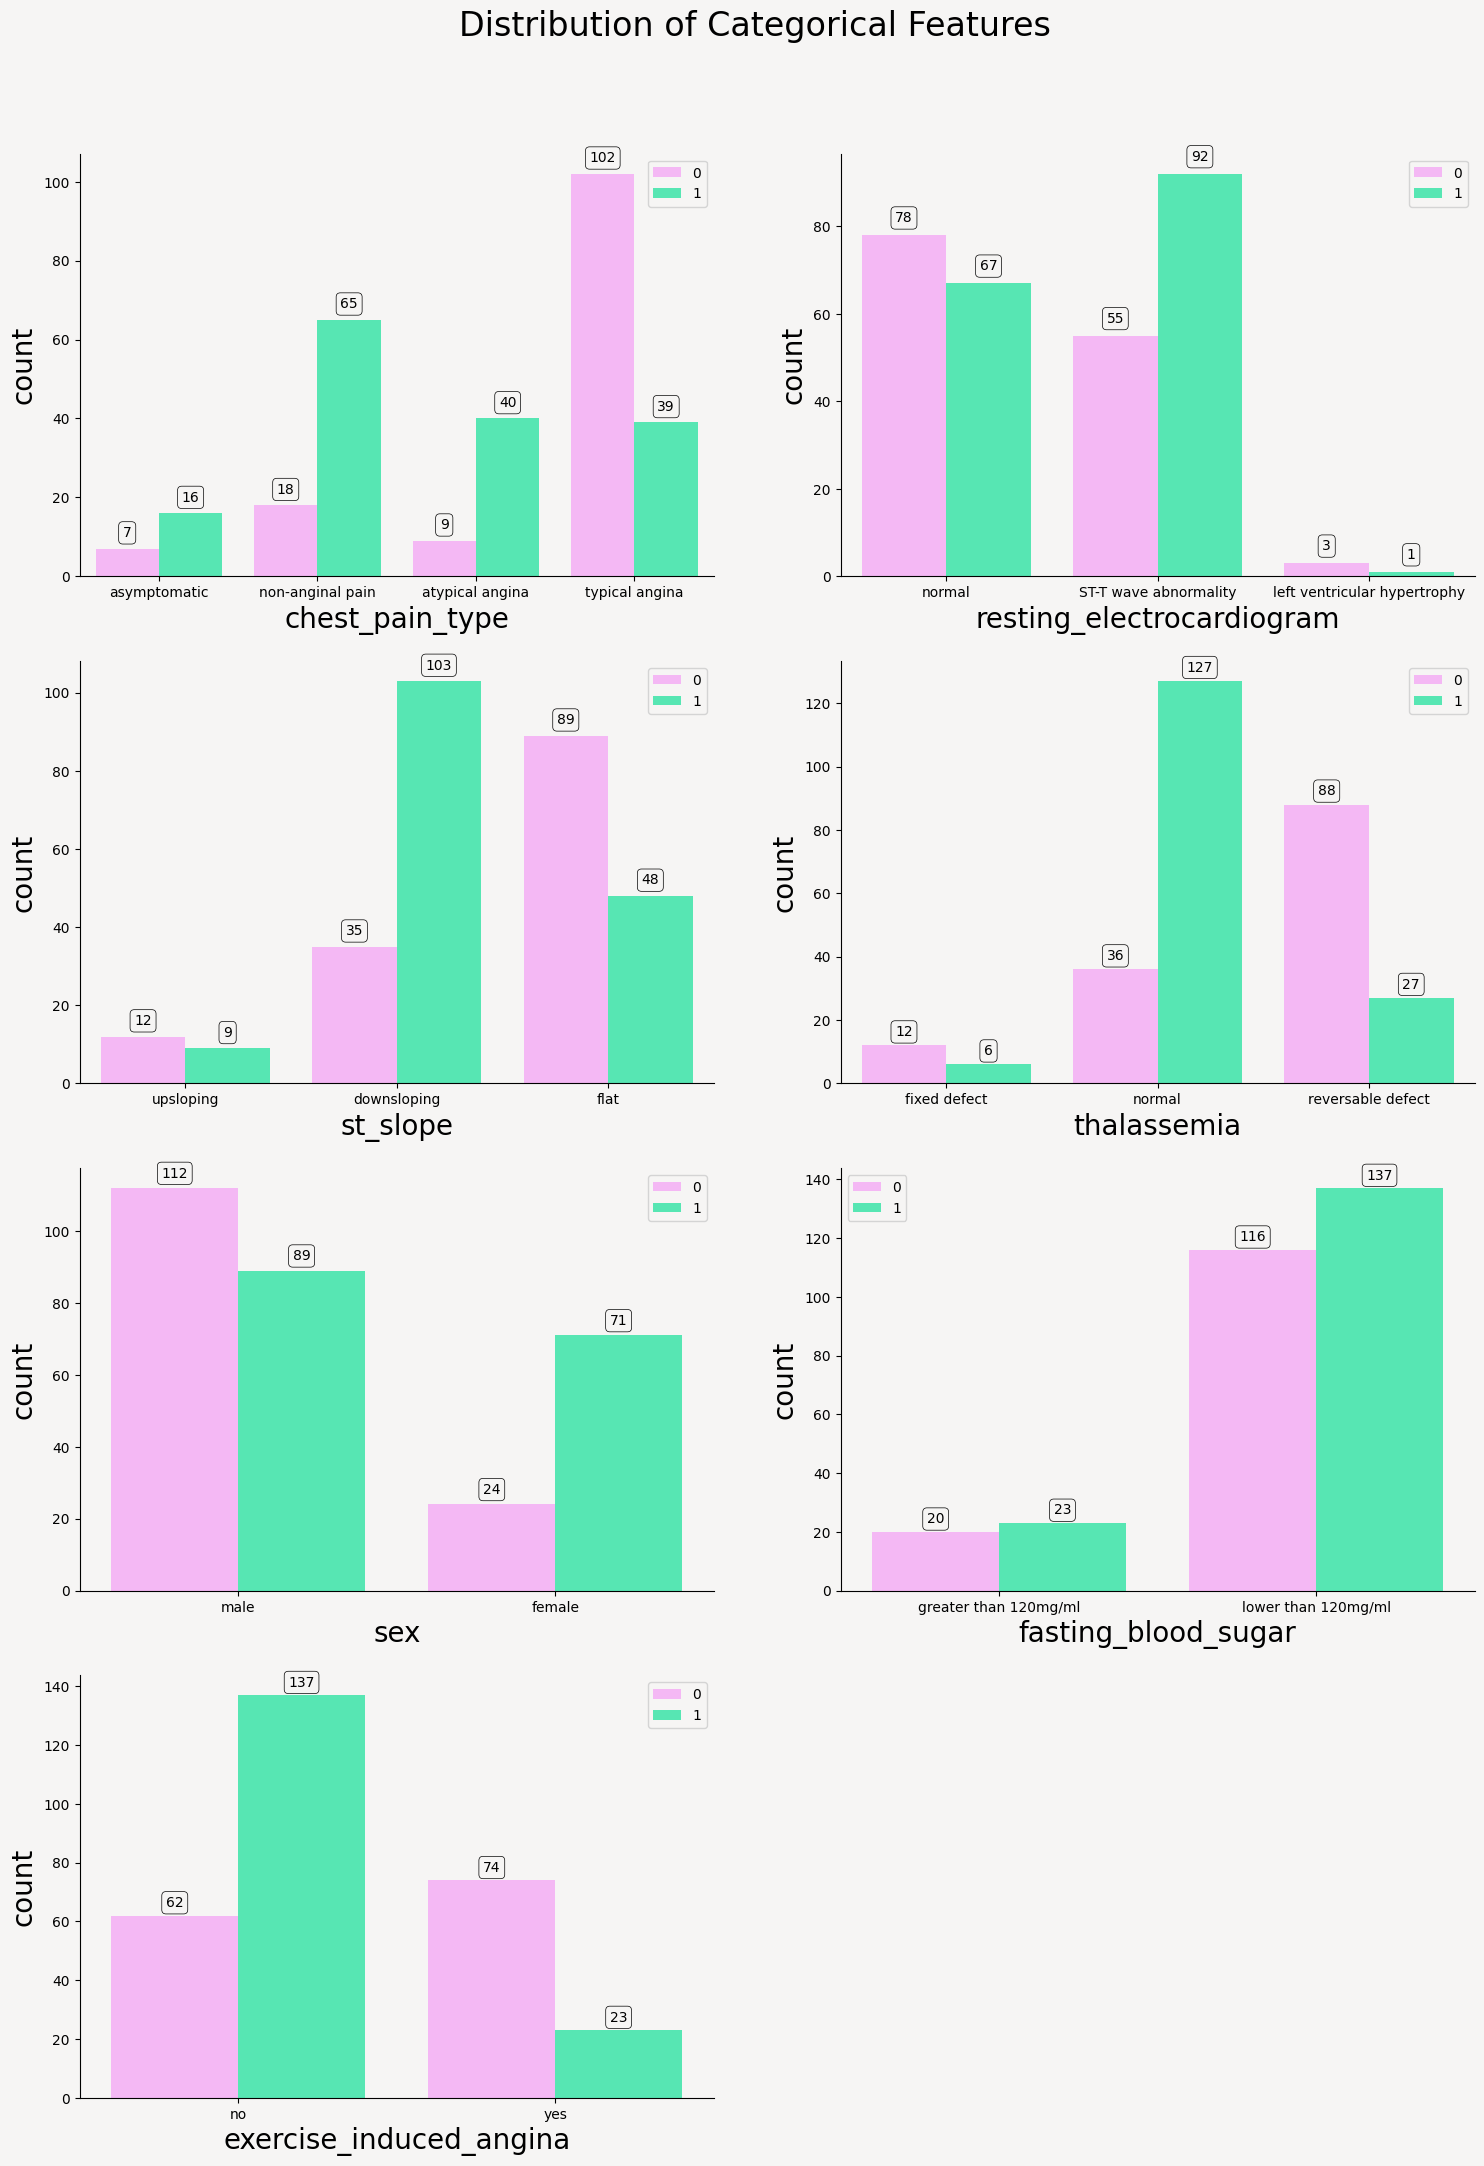

In [ ]:
def count_plot(data, cat_feats):
    L = len(cat_feats)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 24), facecolor='#F6F5F4')
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in cat_feats:
        plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
        ax = sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel("count", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False)
        plt.legend(facecolor='#F6F5F4')

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                  bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

        i = i +1

    plt.suptitle('Distribution of Categorical Features' ,fontsize = 24)
    return 0

count_plot(data, cat_feats[0:-1]);

Corelational heatmap:- Correlation heatmap is a useful tool to graphyically represent how two features are related to eachother. Depending upon the data types of the features, we need to use the appropriate correlation coefficient calculation methods

#Pearson Correlation
The Pearson correlation coefficient ― is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations

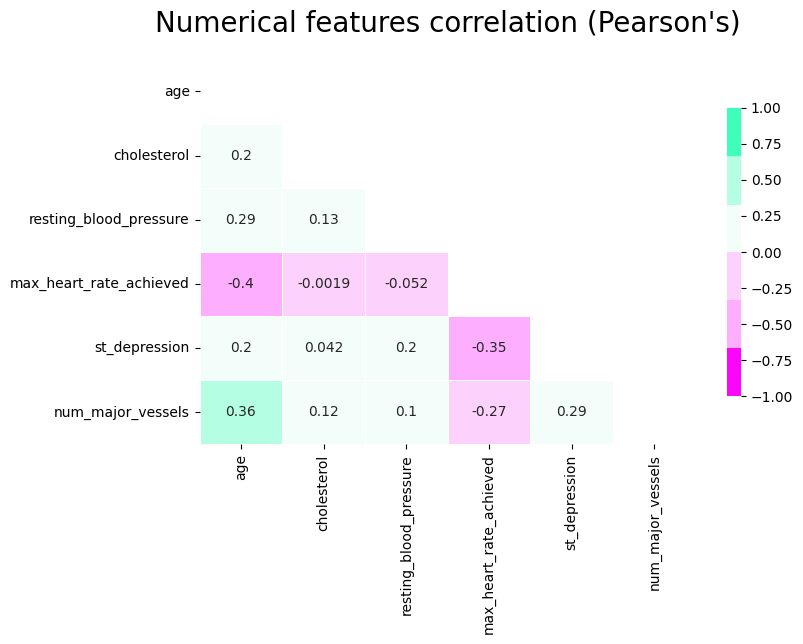

In [ ]:
df_ = data[num_feats]
corr = df_.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=20, y= 1.05);

#Point biserial correlation
A point-biserial correlation is used to measure the strength and direction of the association that exists between one continuous variable and one dichotomous variable

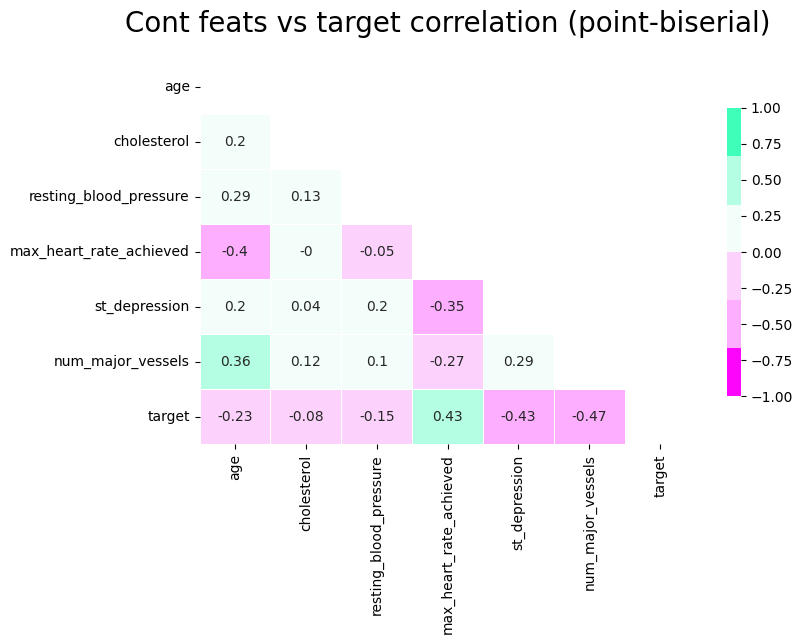

In [ ]:
feats_ = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels', 'target']

def point_biserial(x, y):
    pb = stats.pointbiserialr(x, y)
    return pb[0]

rows= []
for x in feats_:
    col = []
    for y in feats_ :
        pbs =point_biserial(data[x], data[y])
        col.append(round(pbs,2))
    rows.append(col)

pbs_results = np.array(rows)
DF = pd.DataFrame(pbs_results, columns = data[feats_].columns, index =data[feats_].columns)

mask = np.triu(np.ones_like(DF, dtype=bool))
corr = DF.mask(mask)

f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Cont feats vs target correlation (point-biserial)", fontsize=20, y= 1.05);

#Cramers's V Correlation
In statistics, Cramér's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic

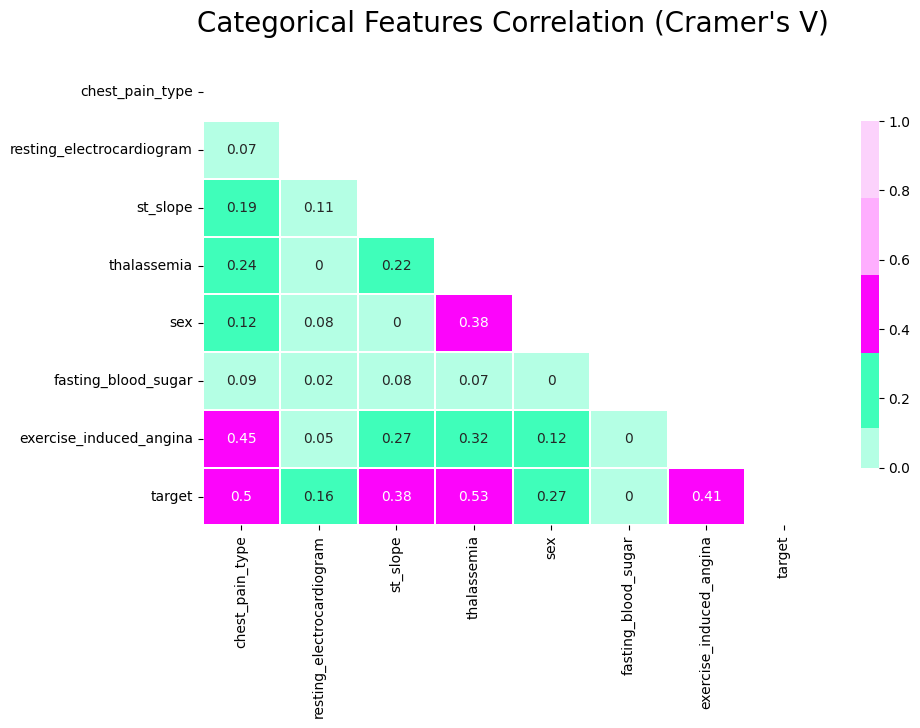

In [ ]:
# the cramers_v function is copied from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# calculate the correlation coefficients using the above function
data_ = data[cat_feats]
rows= []
for x in data_:
    col = []
    for y in data_ :
        cramers =cramers_v(data_[x], data_[y])
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_.columns, index = data_.columns)

# color palette
mypal_1= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA', '#FC05FB', '#FEAEFE', '#FCD2FC']
# plot the heat map
mask = np.triu(np.ones_like(df, dtype=bool))
corr = df.mask(mask)
f, ax = plt.subplots(figsize=(10, 6), facecolor=None)
cmap = sns.color_palette(mypal_1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=20, y= 1.05);

Correlations:
Correlation between features is weak at best

From the numerical features **num_major_vessels, max_heart_rate_achieved and st_depression** are reasonabily fairly correlated with the target variable at -0.47, 0.43 and -0.43 correlation coefficient respectively.


From the categorical features **chest_pain_type, num_major_vessels, thalassemia, and exercise_induced_angina** are better correlated with the target variable, thalassemia being the highest at 0.52.

Cholestrol  has less correlation with heart desease.

Takeaway: features that have higher predictive power could be, **chest_pain_type, num_major_vessels, thalassemia, exercise_induced_angina max_heart_rate_achieved and st_depression**. We will see which features will appear as imporatnt by the classification models.

In [ ]:
!pip install --upgrade scikit-learn


In [ ]:
def label_encode_cat_features(data, cat_features):
    '''
    Given a dataframe and its categorical features, this function returns label-encoded dataframe
    '''

    label_encoder = LabelEncoder()
    data_encoded = data.copy()

    for col in cat_features:
        data_encoded[col] = label_encoder.fit_transform(data[col])

    data = data_encoded

    return data


def score_summary(names, classifiers):
    '''
    Given a list of classiers, this function calculates the accuracy,
    ROC_AUC and Recall and returns the values in a dataframe
    '''

    cols=["Classifier", "Accuracy", "ROC_AUC", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)

    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)

        pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, pred)

        pred_proba = clf.predict_proba(X_val)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
        roc_auc = auc(fpr, tpr)

        # confusion matric, cm
        cm = confusion_matrix(y_val, pred)

        # recall: TP/(TP+FN)
        recall = cm[1,1]/(cm[1,1] +cm[1,0])

        # precision: TP/(TP+FP)
        precision = cm[1,1]/(cm[1,1] +cm[0,1])

        # F1 score: TP/(TP+FP)
        f1 = 2*recall*precision/(recall + precision)

        df = pd.DataFrame([[name, accuracy*100, roc_auc, recall, precision, f1]], columns=cols)
        data_table = data_table.append(df)

    return(np.round(data_table.reset_index(drop=True), 2))


def plot_conf_matrix(names, classifiers, nrows, ncols, fig_a, fig_b):
    '''
    Plots confusion matrices in a subplots.

    Args:
        names : list of names of the classifier
        classifiers : list of classification algorithms
        nrows, ncols : number of rows and rows in the subplots
        fig_a, fig_b : dimensions of the figure size
    '''

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))

    i = 0
    for clf, ax in zip(classifiers, axes.flatten()):

        clf.fit(X_train, y_train)
        plot_confusion_matrix(clf, X_val, y_val, ax=ax)
        ax.title.set_text(names[i])
        i = i + 1

    plt.tight_layout()
    plt.show()


def roc_auc_curve(names, classifiers):
    '''
    Given a list of classifiers, this function plots the ROC curves

    '''
    plt.figure(figsize=(12, 8))

    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)

        pred_proba = clf.predict_proba(X_val)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")


In [ ]:
from sklearn.preprocessing import LabelEncoder


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

In [ ]:
# split the data into train and test sets

cat_features = cat_feats
data = label_encode_cat_features(data, cat_features)

seed = 0
test_size = 0.25

features = data.columns[:-1]

X = data[features]
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, random_state=seed)


# classifier algorithms with default parameters

names = [
    'Logistic Regression',
    'Nearest Neighbors',
    'Support Vectors',
    'Nu SVC',
    'Decision Tree',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
    'Quadratic DA',
    "Neural Net"
]

classifiers = [
    LogisticRegression(solver="liblinear", random_state=seed),
    KNeighborsClassifier(2),
    SVC(probability=True, random_state=seed),
    NuSVC(probability=True, random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(random_state=seed),
]


In [ ]:
from sklearn.metrics import confusion_matrix


Accuracy : Measures how many of the cases are correctly identified/predicted by the model, i.e correct prediction divided by the total sample size.

Accuracy = (𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁)

Recall: Measures the rate of true positives, i.e how many of the actual positive cases are identified/predicted as positive by the model.

Recall= 𝑇𝑃/(𝑇𝑃+𝐹𝑁)

Precision: Measures how many of the positive predicted cases are actually positive.

Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)

F1-Score : Combines the precision and recall of the model and it is defined as the harmonic mean of the model’s precision and recall.

F1 score= 2*(𝑟𝑒𝑐𝑎𝑙𝑙∗𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛/𝑟𝑒𝑐𝑎𝑙𝑙+𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛)

ROC curves : A receiver operating characteristic (ROC) curve, is a graphical plot which illustrates the performance of a binary classification algorithm as a function of ture positive rate and false positive rate.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# Your previous code...

score_summary(names, classifiers).sort_values(by='Accuracy', ascending=False)\
    .style.background_gradient(cmap='coolwarm')\
    .bar(subset=["ROC_AUC"], color='#6495ED')\
    .bar(subset=["Recall"], color='#ff355d')\
    .bar(subset=["Precision"], color='lightseagreen')\
    .bar(subset=["F1"], color='gold')



,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
0,Logistic Regression,86.490000,0.920000,0.910000,0.820000,0.860000
9,Linear DA,85.140000,0.920000,0.890000,0.820000,0.850000
10,Quadratic DA,85.140000,0.900000,0.830000,0.850000,0.840000
5,Random Forest,83.780000,0.920000,0.830000,0.830000,0.830000
4,Decision Tree,82.430000,0.820000,0.830000,0.810000,0.820000
6,AdaBoost,82.430000,0.860000,0.910000,0.760000,0.830000
7,Gradient Boosting,82.430000,0.900000,0.890000,0.780000,0.830000
8,Naive Bayes,82.430000,0.920000,0.860000,0.790000,0.820000
3,Nu SVC,81.080000,0.910000,0.910000,0.740000,0.820000
11,Neural Net,78.380000,0.880000,0.940000,0.700000,0.800000


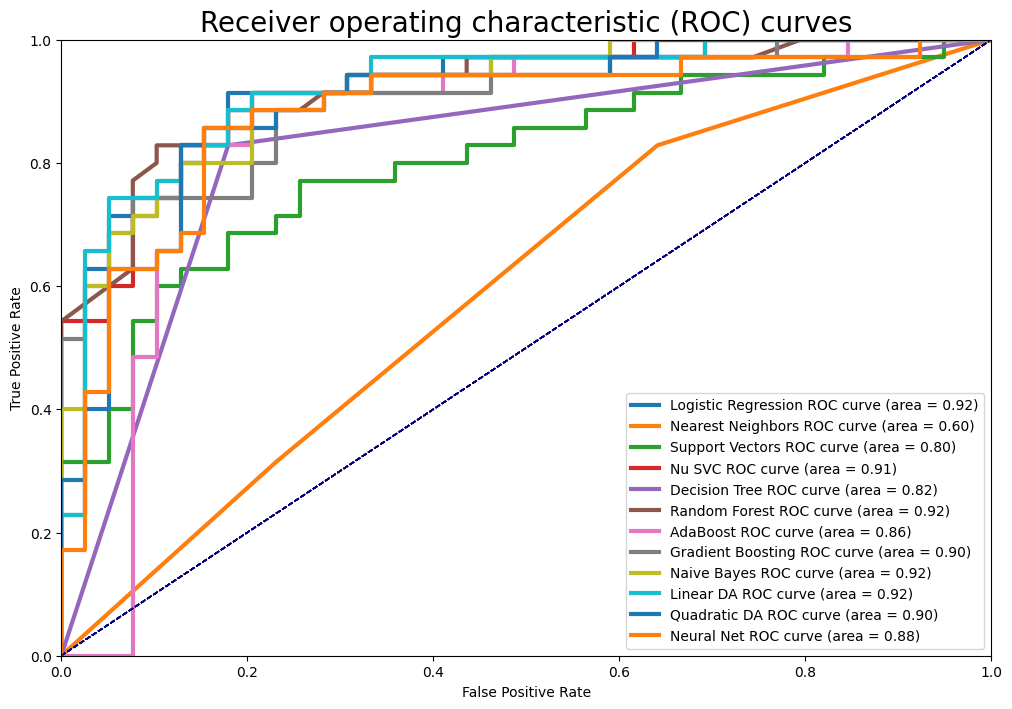

In [ ]:
roc_auc_curve(names, classifiers)

In [ ]:
from sklearn import metrics

Now we have seen all the performance metrics of the classifiers, it is decision time for us to choose the best possible classifier algorithm. Based on precision LR ranks first (86%); whereas if we see the recall, Neural Nets ranks first with 94%. In the case of precision, QDA ranks first with 85%. So which one to choose? The F1-score can give us a balance between recall and precision. LR happens to have the best F1-score so we choose Logistic Regression as our best classifier.

#Randomized Search (Logistic Regression)

So chosen our best classifier, the Logistic regression model. However, this was achieved with default parameters. The intuition is that we could further improve our model with tuned parameters. Let's see if could achieve that using the scikit-learn RandomizedSearch algorithm.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import RepeatedStratifiedKFold


lr = LogisticRegression(tol=1e-4, max_iter=1000, random_state=seed)

space = dict(C=uniform(loc=0, scale=5),
                     penalty=['l2', 'l1'],
                     solver= ['liblinear'])

search = RandomizedSearchCV(lr,
                         space,
                         random_state=seed,
                         cv = 5,
                         scoring='f1')

rand_search = search.fit(X_train, y_train)

print('Best Hyperparameters: %s' % rand_search.best_params_)

Best Hyperparameters: {'C': 0.2835648865872159, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
from sklearn.metrics import classification_report



params = rand_search.best_params_
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))


              precision    recall  f1-score   support

           0       0.91      0.82      0.86        39
           1       0.82      0.91      0.86        35

    accuracy                           0.86        74
   macro avg       0.87      0.87      0.86        74
weighted avg       0.87      0.86      0.86        74



Above we tried to tune the linear regression to increase its accuracy  by using randomized search algo but it turns out that we can't increase it further.

*Gradient Boosting*

Now we will try the modern (boosted trees) ML algorithms such as the catboost, xgboost and lgbm. They are optimized machine learning algorithms based on the gradient-boosting technique.

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [ ]:
!pip install xgboost
!pip install lightgbm

In [ ]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score  # Add this import

names_boost = [
    'CatBoost',
    'XGBoost',
    'LightGBM'
]

classifiers_boost = [
    CatBoostClassifier(random_state=seed, verbose=0),
    XGBClassifier(objective='binary:logistic', random_state=seed),
    LGBMClassifier(random_state=seed)
]

# Create a dictionary to store the results for each classifier
results_boost = {}

# Fit and evaluate each Boosting classifier
for name, clf in zip(names_boost, classifiers_boost):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Store the results in the dictionary
    results_boost[name] = {
        'Accuracy': accuracy,
        'ROC_AUC': roc_auc,
        'Recall': recall,
        'Precision': precision,
        'F1': f1
    }

# Convert the results dictionary to a DataFrame
results_boost_df = pd.DataFrame(results_boost).T

# Sort the results by Accuracy in descending order
results_boost_df = results_boost_df.sort_values(by='Accuracy', ascending=False)

# Apply styling to the DataFrame (similar to your previous code)
styled_results_boost = results_boost_df.style.background_gradient(cmap='coolwarm')\
    .bar(subset=["ROC_AUC"], color='#6495ED')\
    .bar(subset=["Recall"], color='#ff355d')\
    .bar(subset=["Precision"], color='lightseagreen')\
    .bar(subset=["F1"], color='gold')

# Display the styled results
styled_results_boost


[LightGBM] [Info] Number of positive: 125, number of negative: 97
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.563063 -> initscore=0.253603
[LightGBM] [Info] Start training from score 0.253603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Accuracy,ROC_AUC,Recall,Precision,F1
CatBoost,0.837838,0.838828,0.857143,0.810811,0.833333
LightGBM,0.824324,0.826007,0.857143,0.789474,0.821918
XGBoost,0.797297,0.798901,0.828571,0.763158,0.794521


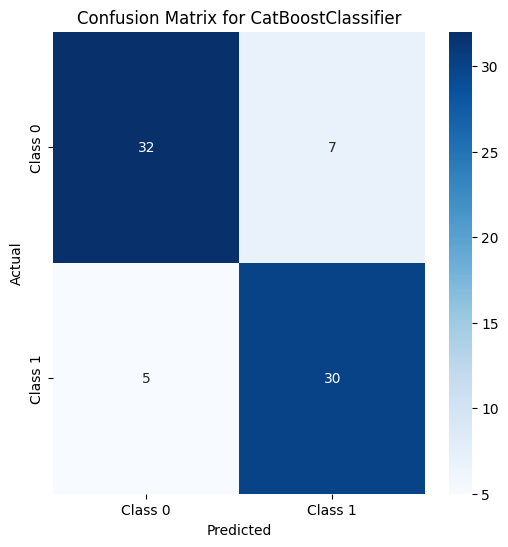

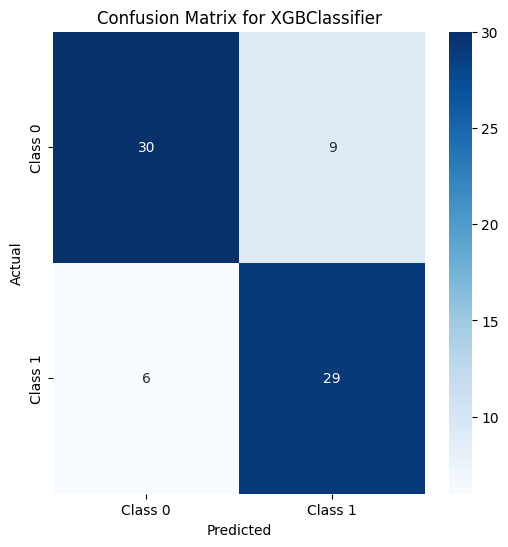

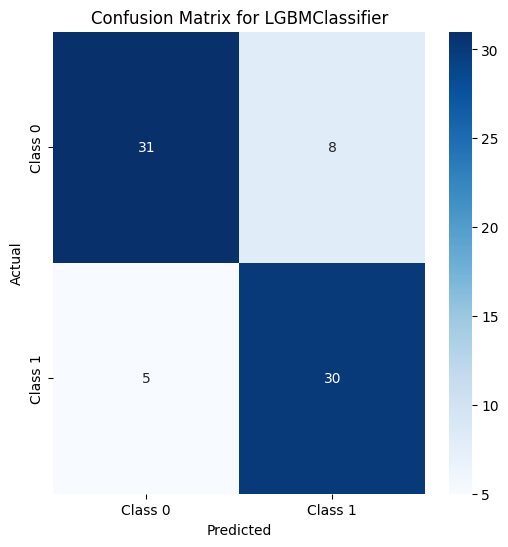

In [ ]:
from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a function to plot the confusion matrix
def plot_confusion_matrix_for_classifier(classifier, X, y, class_labels):
    y_pred = classifier.predict(X)
    conf_matrix = confusion_matrix(y, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {classifier.__class__.__name__}")
    plt.show()

# Plot confusion matrices for CatBoost, XGBoost, and LightGBM
class_labels = ["Class 0", "Class 1"]  # Replace with your class labels

for name, clf in zip(names_boost, classifiers_boost):
    plot_confusion_matrix_for_classifier(clf, X_val, y_val, class_labels)


In [ ]:
from sklearn.metrics import confusion_matrix


Remark:- Here we can see that the lgbm calssifier is marginally better than the other two and we will go for it. Following the same procedure, we will try to tune the parameters in the next section.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

rs_params = {
    'num_leaves': [20, 100],
    'max_depth': [5, 15],
    'min_data_in_leaf': [80, 120],
}
rs_cv = GridSearchCV(estimator=LGBMClassifier(random_state=seed),
                     param_grid=rs_params,
                     cv=5)

rs_cv.fit(X_train, y_train)
params = rs_cv.best_params_

lgbm = LGBMClassifier(**params)

lgbm.fit(X_train, y_train)

print(classification_report(y_val, lgbm.predict(X_val)))


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 100, number of negative: 77
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564972 -> initscore=0.261365
[LightGBM] [Info] Start training from score 0.261365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [ ]:
!pip install scikit-plot


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


<Figure size 600x600 with 0 Axes>

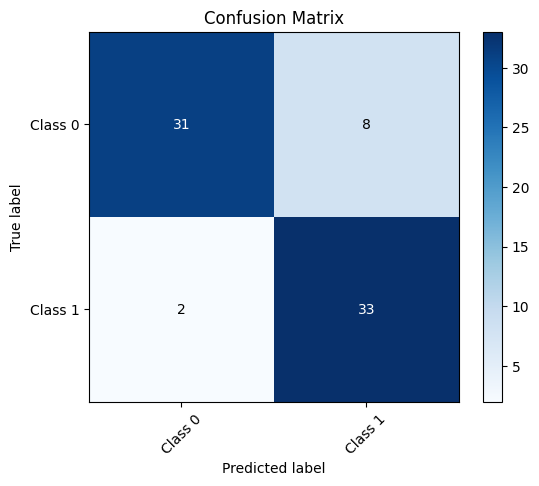

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, lgbm.predict(X_val))

# Plot the confusion matrix
class_names = ["Class 0", "Class 1"]  # Replace with your class labels

plt.figure(figsize=(6, 6))
plot_confusion_matrix(y_val, lgbm.predict(X_val), cmap=plt.cm.Blues)
plt.xticks(range(2), class_names, rotation=45)
plt.yticks(range(2), class_names)
plt.title("Confusion Matrix")
plt.show()


Remark: In this case (Lgbm) hyper-parameter tuning gave better results than the base model. We have increased the recall value from 86% to 94%. Which means we have decrease the rate of false negatives from 5 cases to 2 in our validation set and we have also decreased the false positive cases by 1. Marginal but we will take every percentage point we can get.

SHAP, a short name for SHapely Additive ExPlanations, is a method used to explain the output of a machine learning model.

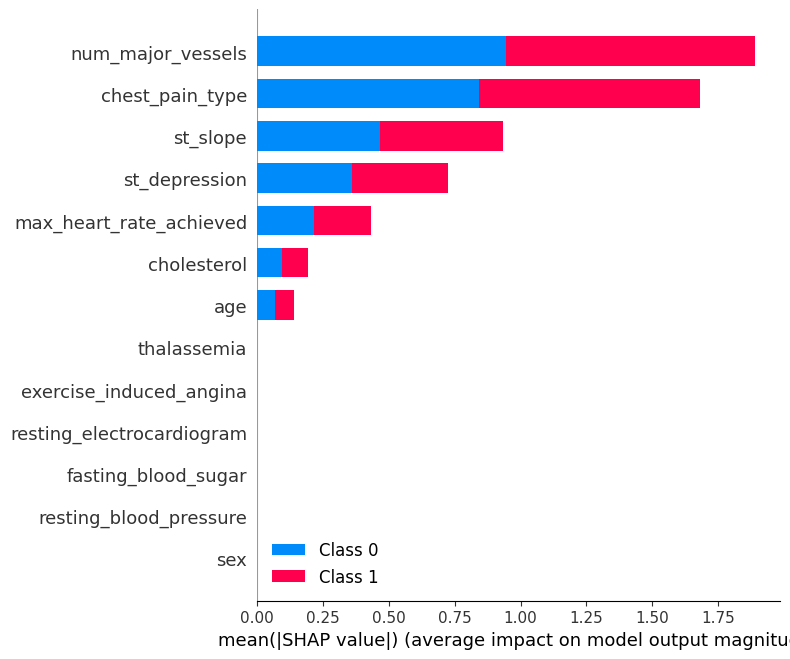

In [ ]:
!pip install shap
import shap
shap.initjs()
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val,
                  feature_names=features,
                  plot_type="bar",
                 )

Conclusion:-

Our best model happens to be LGBM classifier (tuned with randomizedSearch)
According to SHAP the three most important features of the model are num_major_vessels, chest_pain_type, and st_slope. These features are also among better correlated features from our EDA.
Contrary to my intuition cholesterol happens to be not an important feature for the model